In [1]:
import matplotlib.pyplot as plt
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import ExactMolWt
import math

In [2]:
import pandas as pd
import numpy as np

In [107]:
df = pd.read_csv("dextrose_wet_impcols.csv")#39_Formose reaction_MeOH.csv
print(df.columns)

Index(['Peak Number', 'Mass', 'Rel. Abundance', 'Kendrick Mass', 'Nom. Mass',
       'KMD', 'Molecular Formula'],
      dtype='object')


In [108]:
# first get rid of empty lines in the mass list by replacing with ''
df.replace('', np.nan, inplace=True)
# also, some 'Mass' values are not numbers
df.dropna(subset=['Mass'], inplace=True)
# now replace NaNs with '' to avoid weird errors
df.fillna('', inplace=True)
df.shape
df.head()


,Peak Number,Mass,Rel. Abundance,Kendrick Mass,Nom. Mass,KMD,Molecular Formula
0,1,296.10679,7.4044,295.7762,296.0,224.0,No Hit
1,2,514.28440,3.1185,513.7102,514.0,290.0,
2,3,360.12282,1.9340,359.7207,360.0,279.0,No Hit
3,4,444.14395,0.0246,443.6480,444.0,352.0,No Hit
4,5,458.15959,1.5455,457.6480,458.0,352.0,No Hit


In [109]:
# make a list of exact mass and relative abundance.
mass_list = []
rel_abundance = []
for i in range(len(df)):
    if float(df['Mass'].iloc[i]) < 200 and "No Hit" not in df['Molecular Formula'].iloc[i]:
        mass_list.append(float(df['Mass'].iloc[i]))
        rel_abundance.append(float(df['Rel. Abundance'].iloc[i]))
# now, "renormalize" the relative abundance.
highest = max(rel_abundance)
norm_factor = 100.0/highest
normalized_abun = []
for ab in rel_abundance:
    normalized_abun.append(norm_factor*ab)
print(f'{len(mass_list)} items in {mass_list}')


32 items in [195.0299, 179.05612, 189.04047, 195.05103, 193.01425, 179.03499, 193.05064, 183.0299, 197.04555, 177.01934, 191.03499, 193.03538, 199.04007, 185.04556000000002, 199.0612, 177.05573, 191.07137, 181.05064, 195.06628, 175.04008000000002, 189.05572, 183.06628999999998, 197.08194, 161.04556000000002, 187.04007, 173.04555, 187.0612, 179.07137, 177.04047, 191.05612, 185.08194, 181.08702]


It turns out that all weights below MW < 160 had no hit for a molecular formula by the spectrometer.

Now check for any peaks in the spectrum that match our model

195.0299 got matched in gen 5. It corresponds to MW 196.037176
179.05612 got matched in gen 1. It corresponds to MW 180.06339599999998
189.04047 got matched in gen 3. It corresponds to MW 190.047746
195.05103 got matched in gen 1. It corresponds to MW 196.058306
179.03499 got matched in gen 5. It corresponds to MW 180.04226599999998
183.0299 got matched in gen 4. It corresponds to MW 184.037176
197.04555 got matched in gen 4. It corresponds to MW 198.05282599999998
193.03538 got matched in gen 3. It corresponds to MW 194.042656
185.04556000000002 got matched in gen 4. It corresponds to MW 186.052836
181.05064 got matched in gen 5. It corresponds to MW 182.05791599999998
195.06628 got matched in gen 5. It corresponds to MW 196.073556
183.06628999999998 got matched in gen 5. It corresponds to MW 184.07356599999997
197.08194 got matched in gen 5. It corresponds to MW 198.089216
161.04556000000002 got matched in gen 1. It corresponds to MW 162.052836
173.04555 got matched in gen 3. It corr

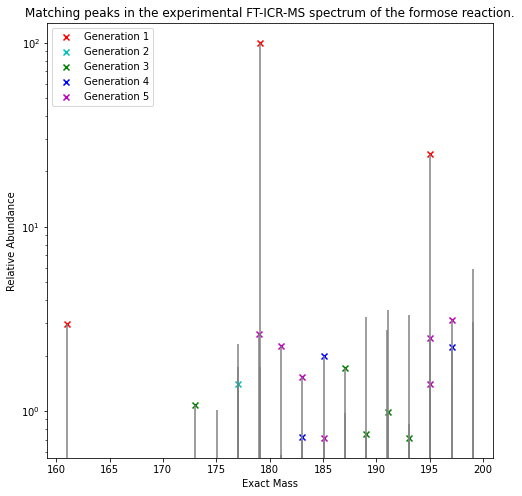

In [112]:
# for some flexibility, create a container for the figure
fig = plt.figure(figsize=(8,8)) # create a figure object
ax = fig.add_subplot(111) # create an axis object

# first, draw the experimental spectrum
plt.vlines(x=mass_list, ymin=0, ymax=normalized_abun, color='gray')
plt.yscale('log')
#plt.ylim([0.875, 125])

# now, look at the simulated network for matches. Calculate mass using RDKit
wt_gen_dict = {} # a dictionary {weight:generation it first appeared in}

with open("../main/glucose/glucose_degradation_output.txt") as out:
    lines = out.readlines()
    # a dictionary in which we'll store the smiles string
    # and the generation in which it first appeared
    smiles_gen_dict = {}
    for line in lines:
        line_comps = line.split('\t') #items in the line are separated by a tabspace
        smiles_gen_dict[line_comps[1]] = line_comps[0][1] #2nd character of component 0 is the generation number
    
    for smiles, gen in smiles_gen_dict.items():
        #print(gen+"--->"+smiles)
        mol = MolFromSmiles(smiles)
        wt = ExactMolWt(mol)
        if wt not in wt_gen_dict:    
            wt_gen_dict[wt]=gen

proton_mass = 1.007276

matching_mass_list = []
match_gen_list = []
# check every peak in the exp spectrum
for obs_mass in mass_list:
    for sim_weight, gen in wt_gen_dict.items():
        if abs((sim_weight - proton_mass) - obs_mass) < 0.0001:
            print(f'{obs_mass} got matched in gen {gen}. It corresponds to MW {obs_mass + proton_mass}')
            matching_mass_list.append(obs_mass)
            match_gen_list.append(int(gen))
            break
# it will be convenient to plot these by generation if I separated them by gen into a map
round_match_dict = {}
for i in range(len(match_gen_list)):
    # if this gen id is in the map,
    if match_gen_list[i] in round_match_dict.keys():
        round_match_dict[match_gen_list[i]].append(matching_mass_list[i])
    else:
        # each value corresponding to a gen is supposed to be a list of masses (same as those in exp spectrum)
        round_match_dict[match_gen_list[i]] = [matching_mass_list[i]]

# we want to color the markers by generation
colors = ['r', 'c', 'g', 'b', 'm', 'k']
for gen_app, matches_list in round_match_dict.items():
    # fetch the abundances of each subset of matching peaks
    mass_abuns = []
    for mass in matches_list:
        mass_abuns.append(normalized_abun[mass_list.index(mass)])
    #print(f"Matches list: {matches_list}")
    #print(f"Abundances: {mass_abuns}")
    plt.scatter(matches_list, mass_abuns, marker='x', color=colors[gen_app-1], label=f'Generation {gen_app}')

# also, check for matches with 13-C isotope peaks. 
c13_matching_masses = []
c13_match_gens = []
# need to add this to get the mass of 13-C carbon
c13_correction = 1.003355

# now repeat the above exercise
# check every peak in the exp spectrum
for obs_mass in mass_list:
    for sim_weight, gen in wt_gen_dict.items():
        if abs((sim_weight - proton_mass + c13_correction) - obs_mass) < 0.0001:
            print(f'{obs_mass} with 13-C got matched in gen {gen}. It corresponds to MW {obs_mass - c13_correction + proton_mass} w/o C-13')
            c13_matching_masses.append(obs_mass)
            c13_match_gens.append(int(gen))
            break

c13_gen_match_dict = {}
for i in range(len(c13_matching_masses)):
    # if this gen id is in the map,
    if c13_match_gens[i] in c13_gen_match_dict.keys():
        c13_gen_match_dict[c13_match_gens[i]].append(c13_matching_masses[i])
    else:
        # each value corresponding to a gen is supposed to be a list of masses (same as those in exp spectrum)
        c13_gen_match_dict[c13_match_gens[i]] = [c13_matching_masses[i]]

for gen_app, matches_list in c13_gen_match_dict.items():
    # fetch the abundances of each subset of matching peaks
    mass_abuns = []
    for mass in matches_list:
        mass_abuns.append(normalized_abun[mass_list.index(mass)])

    plt.scatter(matches_list, mass_abuns, marker='o', s=20, color=colors[gen_app-1], label=f'Generation {gen_app} ' + '(C$^{13}$)')

plt.xlabel('Exact Mass')
plt.ylabel('Relative Abundance')
plt.title('Matching peaks in the experimental FT-ICR-MS spectrum of the formose reaction.')

# add a legend
# make the entries in the legend order by generation in ascending order
handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels), key=lambda list: list[1])
h, l = zip(*hl)
plt.legend(h, l, loc='upper left')
plt.savefig('formose_6_ms.jpg', dpi=300)
plt.show()

In [113]:
print(f'There are total {len(matching_mass_list) + len(c13_matching_masses)} matches out of {len(mass_list)} total peaks in this range in the mass spectra')

There are total 19 matches out of 32 total peaks in this range in the mass spectra


In [ ]:
# This is old code I was using before. Should be ignored
'''# open the output.txt
weights_dict = {} # a dictionary {weight:generation it first appeared in}

with open("formose_output.txt") as out:
    lines = out.readlines()
    # a dictionary in which we'll store the smiles string
    # and the generation in which it first appeared
    smiles_gen_dict = {}
    for line in lines:
        line_comps = line.split('\t') #items in the line are separated by a tabspace
        smiles_gen_dict[line_comps[1]] = line_comps[0][1] #2nd character of component 0 is the generation number
    
    for smiles, gen in smiles_gen_dict.items():
        #print(gen+"--->"+smiles)
        mol = MolFromSmiles(smiles)
        wt = ExactMolWt(mol)
        if wt not in weights_dict:    
            weights_dict[wt]=gen # This part only see the last matching in generation for a specific mass

espectro = open('formose_ms.csv','r')
lines = espectro.readlines()
#plt.ylim([0, 100])

#obs_mass = [] # list of masses in the glucose.csv
#rel_abundance = [] # rel abundance
match_gen = [] # entry is 0 if not matched, else is set equal generation of first appearance
# check for matches with MOD output
proton_mass = 1.007276
for mass in mass_list:
    found = False
    gen_app = 0
    #print(weights_dict)
    for sim_mass, gen in weights_dict.items():
        if abs((mass + proton_mass) - sim_mass) <= 0.0001:
            found = True
            gen_app=gen
            print(f"{mass} (intensity: {rel_abundance[obs_mass.index(mass)]}) appeared in {gen_app}")
        if found == True:
            match = int(gen_app)
            break
        else:
            match = 0
    match_gen.append(match) 

# Now, mark the matching peaks and color them by generation
# diff color for each generation, add a legend
# to fix issues with legend, I had to make a dictionary for matches by generation

gen_mass_match = {}
for i in range(len(mass_list)):
    if match_gen[i] in gen_mass_match.keys():
        gen_mass_match[match_gen[i]].append(mass_list[i])
    else:
        gen_mass_match[match_gen[i]] = [mass_list[i]]

# Now, place the markers, labelled by generation
colors= ['r','c','g','b','m','k']
for match_gen, mass_list in gen_mass_match.items():
    # I needed the index of the mass in the list obs_mass
    intensities = [rel_abundance[mass_list.index(mass)] for mass in mass_list]
    if match_gen != 0:
        plt.scatter(mass_list, intensities, marker='x', color=colors[match_gen-2], label = f"Generation {match_gen}")
#Glucose info 
mod_glucose_smiles="C(C1C(C(C(C(O)O1)O)O)O)O"
mod_glucose_mass= 180.063388104       
a = mod_glucose_mass - proton_mass
print(f'Calculated mass of glucose: {a}')
        
plt.xlabel("Exact Mass")
plt.ylabel("Relative Abundance")
plt.yscale("log")
#legend should be ordered by generation number
import operator
handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels), key= operator.itemgetter(1))
h,l = zip(*hl)
ax.legend(h, l, loc="upper left")
plt.title("Matching peaks in experimental FT-ICR-MS data for the formose reaction")
plt.savefig("formose_mass_spectra6.jpg", dpi=300, transparent=False)
plt.show()'''

In [114]:
# There are values with negative KMD assigned by the spectrometer??
for i in range(len(df['KMD'])):
    if float(df['KMD'].iloc[i]) < 0 and "No Hit" not in df['Molecular Formula'].iloc[i]:
        print(df.iloc[i])

Peak Number               27
Mass                 603.852
Rel. Abundance        0.3055
Kendrick Mass        603.178
Nom. Mass                604
KMD                     -178
Molecular Formula           
Name: 26, dtype: object
Peak Number               28
Mass                 678.198
Rel. Abundance        0.2996
Kendrick Mass        677.441
Nom. Mass                678
KMD                     -441
Molecular Formula          *
Name: 27, dtype: object
Peak Number               68
Mass                 562.107
Rel. Abundance        0.0241
Kendrick Mass         561.48
Nom. Mass                562
KMD                     -480
Molecular Formula          *
Name: 67, dtype: object
Peak Number               69
Mass                 576.123
Rel. Abundance         0.153
Kendrick Mass         575.48
Nom. Mass                576
KMD                     -480
Molecular Formula          *
Name: 68, dtype: object
Peak Number               70
Mass                 604.154
Rel. Abundance        0.0137
Kendr

Peak Number             1284
Mass                 681.219
Rel. Abundance         0.017
Kendrick Mass        680.458
Nom. Mass                681
KMD                     -458
Molecular Formula           
Name: 2453, dtype: object
Peak Number             1285
Mass                  589.12
Rel. Abundance        0.0178
Kendrick Mass        588.462
Nom. Mass                589
KMD                     -462
Molecular Formula          *
Name: 2454, dtype: object
Peak Number             1286
Mass                 603.135
Rel. Abundance        0.0288
Kendrick Mass        602.462
Nom. Mass                603
KMD                     -462
Molecular Formula          *
Name: 2455, dtype: object
Peak Number             1287
Mass                 617.151
Rel. Abundance        0.0738
Kendrick Mass        616.462
Nom. Mass                617
KMD                     -462
Molecular Formula          *
Name: 2456, dtype: object
Peak Number             1288
Mass                 645.182
Rel. Abundance        0.03

Peak Number             2053
Mass                 759.157
Rel. Abundance        0.0128
Kendrick Mass        758.309
Nom. Mass                759
KMD                     -309
Molecular Formula          *
Name: 3222, dtype: object
Peak Number             2054
Mass                 773.172
Rel. Abundance        0.0134
Kendrick Mass        772.309
Nom. Mass                773
KMD                     -309
Molecular Formula          *
Name: 3223, dtype: object
Peak Number             2055
Mass                 787.188
Rel. Abundance        0.0199
Kendrick Mass        786.309
Nom. Mass                787
KMD                     -309
Molecular Formula          *
Name: 3224, dtype: object
Peak Number             2056
Mass                 759.214
Rel. Abundance        0.0199
Kendrick Mass        758.366
Nom. Mass                759
KMD                     -366
Molecular Formula          *
Name: 3225, dtype: object
Peak Number             2057
Mass                 713.151
Rel. Abundance        0.01

In [115]:
# What mass does RDKit say, glucose has?
glucose_mol = MolFromSmiles("C(C1C(C(C(C(O)O1)O)O)O)O")
glucose_wt = ExactMolWt(glucose_mol)
print("RDKit calculated glucose weight", glucose_wt)

RDKit calculated glucose weight 180.063388104
